In [1]:
import pandas as pd
PATH_DATA = "data"
df_raw = pd.read_csv(
    f"{PATH_DATA}/lote1.csv",
    sep=";",
    quotechar='"',
    encoding="utf-8",
    engine="python",
    on_bad_lines="skip"
)


Qual é a ideia:
- a partir de dados facilmente extraíveis em exames / dados clínicos, estimar a probabilidade da pessoa estar doente de covid por exemplo
- isso presume que
- - é necessário retirar campos que 

Perguntas:
- retirar pessoas sem cpf (dificil demais de lidar)
- a Covid atinge mais qual raça?
- ser profissional da segurança ou de saúde impacta em algo?
- sexo impacta em algo?
- é possível se ter uma ideia de municipios afetados? fazendo algo com geolocalização por exemplo (centro, periferia, zona rural)
- estrangeiros são mais suscetíveis?
- as condições do paciente (outras coisas que ele tem) influencia nos sintomas ou algo do tipo?
- qual é a distribuição por estado? e de forma temporal?
- importante considerar a evolucao do caso
- classificação final tem coisas importantes: considerar o descartado e o confirmado laboratorial
- faixa de idade influencia na evolucao do caso? (cura, óbito, etc)
- internado e internado em UTI para a classificação final devem estar juntos? faz sentido tentar predizer a internação? Vale a pena retirar junto com tratamento domiciliar ou só deixo?
- vale a pena retirar os que possuem evolucaoCaso == Ignorado?
- é possível mapear sintomas e outrosSintomas com espaço de embeddings para tentar uma classificação de baixo,médio e alto risco? É importante fazer a verificação de texto "Outros" pra juntar com o outrosSintomas. 
- CBO mostra as profissões. É possível fazer um embedding com redução de dimensionalidade e clustering pra tentar pegar áreas como "saúde", "educação", "segurança". Os de saúde e de segurança já existem como colunas fixas no dataset, então dá pra usar UMAP supervisionado para reduzir a dimensionalidade do embedding.
- para praticamente todos os casos em que se trabalhar com embedding, precisa utilizar mapeamento com unique pq são dados demais. Dá pra usar alguma classe pra fazer isso.

In [2]:
aaa = ['evolucaoCaso']
print(df_raw[aaa].value_counts()[:30])

print("\n")

aaa = ['classificacaoFinal']
print(df_raw[aaa].value_counts()[:30])
# df_raw[aaa].info()

evolucaoCaso            
Cura                        563340
Ignorado                     70009
Cancelado                    27748
Em tratamento domiciliar      9333
Óbito                         1017
Internado                      370
Internado em UTI                90
Name: count, dtype: int64


classificacaoFinal               
Descartado                           351482
Confirmado Laboratorial              160498
Síndrome Gripal Não Especificada     138989
Confirmado Clínico-Epidemiológico      3741
Confirmado por Critério Clínico        3376
Confirmado Clínico-Imagem               172
Name: count, dtype: int64


In [3]:
df_raw['municipioNotificacao'].value_counts()[:10]

municipioNotificacao
São Paulo                217374
São José do Rio Preto     40854
Barueri                   33887
Campinas                  29875
Catanduva                 26624
Pindamonhangaba           24982
Guarulhos                 21912
Marília                   21709
São José dos Campos       18038
Caraguatatuba             16990
Name: count, dtype: int64

In [4]:
important_columns = [a for a in list((df_raw.columns)) if 
                     ('dat' not in a and
                      'codig' not in a and
                      'estad' not in a and
                      'lot' not in a and
                      'ibge' not in a.lower() and
                      'outroBuscaAtivaAssintomatico'!=a and
                      'outroTriagemPopulacaoEspecifica'!=a and 
                      'outroLocalRealizacaoTestagem'!=a and
                      'source_id'!=a and
                      'excluido'!=a and
                      'validado'!=a and
                      'origem'!=a and
                      'municipioNotificacao'!=a)]
df = df_raw[important_columns]

## retira pessoas sem sintomas
df = df.dropna(subset='sintomas',axis=0)
print("Len df: ",len(df))
important_columns

Len df:  873387


['sintomas',
 'profissionalSaude',
 'racaCor',
 'outrosSintomas',
 'outrasCondicoes',
 'profissionalSeguranca',
 'cbo',
 'condicoes',
 'sexo',
 'municipio',
 'evolucaoCaso',
 'classificacaoFinal',
 'totalTestesRealizados',
 'idade']

## Tratando com sintomas

In [5]:
## Mostrando como o texto 'Outros' aparece
outros_sintomas = df['sintomas'].str.contains('outros', na=False,case=False)
df.loc[outros_sintomas, 'sintomas'].head(10)

9                                                Outros
12                                Outros, Dor de Cabeça
22                                Outros, Dor de Cabeça
24                              Dor de Garganta, Outros
29                                        Tosse, Outros
37                                               Outros
40                       Dor de Garganta, Outros, Tosse
43    Coriza, Distúrbios Olfativos, Distúrbios Gusta...
44                                               Outros
46                         Febre, Tosse, Coriza, Outros
Name: sintomas, dtype: object

Como o texto "Outros" pode aparecer em várias posições, vou fazer um limpador de texto (já foi verificado que o texto é sempre "Outros" e não possui variações como "Outro", "Outra" etc)

In [6]:
texts = df.loc[outros_sintomas, 'sintomas'].head(10).unique().tolist()

def clear_outros(text:str,replace={
    'Outros, ':'',
    ', Outros':'',
    'Outros':'',
}):
    text_aux = text.lower()
    for string,rep in replace.items():
        text_aux = text_aux.replace(string.lower(),rep)
    return text_aux

for text in texts:
    cleaned = clear_outros(text)
    print(f"[{text}] -> [{cleaned}]")

[Outros] -> []
[Outros, Dor de Cabeça] -> [dor de cabeça]
[Dor de Garganta, Outros] -> [dor de garganta]
[Tosse, Outros] -> [tosse]
[Dor de Garganta, Outros, Tosse] -> [dor de garganta, tosse]
[Coriza, Distúrbios Olfativos, Distúrbios Gustativos, Tosse, Dispneia, Outros] -> [coriza, distúrbios olfativos, distúrbios gustativos, tosse, dispneia]
[Febre, Tosse, Coriza, Outros] -> [febre, tosse, coriza]


In [7]:
df['sintomas_clear'] = df['sintomas'].map(clear_outros)
df['sintomas_clear'].head()

0                   assintomático
1                   assintomático
2    coriza, dor de cabeça, tosse
3                   assintomático
4                   assintomático
Name: sintomas_clear, dtype: object

Existem as colunas Sintomas e OutrosSintomas, então vou fazer um merging do texto das duas

In [8]:
df['sintomas_total'] = (df['sintomas_clear'].map(lambda text: text+', ' if len(text)>0 else text)).str.cat(df['outrosSintomas'].str.lower(),na_rep='')
df[['sintomas','outrosSintomas','sintomas_total']][df['outrosSintomas'].notnull()].head()

,sintomas,outrosSintomas,sintomas_total
9,Outros,"VERTIGEM, CALAFRIO, MIALGIA INTESA","vertigem, calafrio, mialgia intesa"
12,"Outros, Dor de Cabeça","NÁUSEA, DOR NAS COSTAS E NAS PERNAS","dor de cabeça, náusea, dor nas costas e nas pe..."
22,"Outros, Dor de Cabeça",SINTOMAS GRIPAIS,"dor de cabeça, sintomas gripais"
24,"Dor de Garganta, Outros",CALAFRIO,"dor de garganta, calafrio"
29,"Tosse, Outros",PERDA DO PALDAR,"tosse, perda do paldar"


Agora que os sintomas estão organizados, separamos por vírgula

In [9]:
unSint2index = {} ## guarda a relação 'sintoma':[index1,index2...] em que ele aparece
for idx,sintomas in df['sintomas_total'].items(): 
    for sintoma in sintomas.replace("/",",").split(','):
        if len(sintoma.replace(' ',''))==0: ## tira textos vazios
            continue
        sintoma = sintoma[1:] if sintoma[0]==' ' else sintoma
        if sintoma in unSint2index.keys():
            unSint2index[sintoma].append(idx)
        else:
            unSint2index[sintoma] = [idx,]

In [10]:
len(unSint2index)

36035

In [11]:
iter_dict = iter(unSint2index.items())
for i in range(100):
    sintoma,idxs = next(iter_dict)
    print(f"{sintoma:50}| qtd idxs:{len(idxs)}")

assintomático                                     | qtd idxs:210601
coriza                                            | qtd idxs:255309
dor de cabeça                                     | qtd idxs:298996
tosse                                             | qtd idxs:376407
dispneia                                          | qtd idxs:93903
dor de garganta                                   | qtd idxs:273627
febre                                             | qtd idxs:213265
vertigem                                          | qtd idxs:333
calafrio                                          | qtd idxs:2475
mialgia intesa                                    | qtd idxs:1
náusea                                            | qtd idxs:858
dor nas costas e nas pernas                       | qtd idxs:4
distúrbios olfativos                              | qtd idxs:55884
distúrbios gustativos                             | qtd idxs:62257
sintomas gripais                                  | qtd idxs:923
perd

Agora que temos o texto bonitinho de todo mundo, vamos fazer um embedding usando o sentence transformer

In [12]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
all_sintomas = list(unSint2index.keys())

In [14]:
# embeddings = model.encode(all_sintomas)

In [15]:
# import dill as dl
# with open('embeddings_sintomas.pkl','wb') as f:
#     dl.dump(embeddings,f)

In [16]:
import dill as dl
with open('embeddings_sintomas.pkl','rb') as f:
    embeddings = dl.load(f)

In [17]:
import umap
min_dist = 0.1
n_neighbors=100
n_components=10

mapper = umap.UMAP(metric='cosine', 
                  min_dist=min_dist,
                  n_neighbors=n_neighbors,
                  n_components=n_components,
                  random_state=42, 
                  low_memory=True).fit(embeddings)

/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [18]:
mapper2d = umap.UMAP(metric='cosine', 
                  min_dist=0.1,
                  n_neighbors=200,
                  n_components=2,
                  random_state=42, 
                  low_memory=True).fit(embeddings)

/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [19]:
data2d = mapper2d.transform(embeddings)

/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


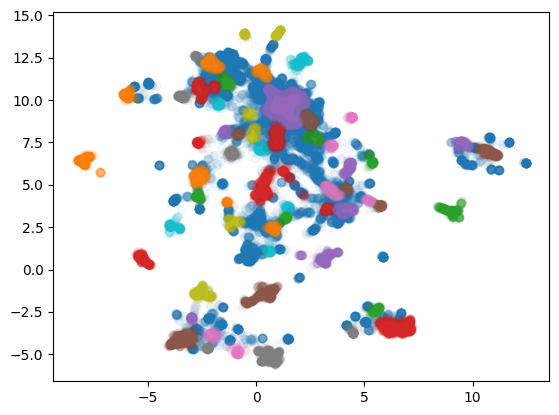

In [20]:
import matplotlib.pyplot as plt
import hdbscan
import numpy as np

clusterer = hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=0.1)

clusterer.fit(data2d)

unique_labels = np.unique(clusterer.labels_)

for label in unique_labels:
    idx = clusterer.labels_==label
    plt.scatter(data2d[idx,0],data2d[idx,1],alpha=0.05)
plt.show()

In [21]:
import matplotlib.pyplot as plt
import hdbscan
import numpy as np

clusterer = hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=0.1)

data10d = mapper.transform(embeddings)
clusterer.fit(data10d)
unique_labels = np.unique(clusterer.labels_)

/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [22]:
print("Quantidade de clusters: ",len(unique_labels))
for label in unique_labels[:30]:
    if label == -1:
        continue
    idx = np.where(clusterer.labels_==label)[0]
    sintomas_cluster = [all_sintomas[i] for i in idx]
    print(f"[{label:2} | {len(sintomas_cluster)}]: {sintomas_cluster[:10]}")

Quantidade de clusters:  68
[ 0 | 1603]: ['dor nos olhos', 'tontura e dor nos olhos', 'ardencia nos olhos', 'dor nos olhos - cansaço', 'ardencia no olho.', 'ardencia olhos', 'dor fundo do olho', 'irritação nos olhos', 'espirros e irritação ocular', 'dor no fundo dos olhos']
[ 1 | 506]: ['falta de apetite', 'dor no corpo e perda de apetite', 'perca de apetite', 'perda apetite; boca amarga', 'refere falta de apetite e dor muscular.', 'diminuiu ingesta alimentar', 'perda de apetite ', 'perda de apetite', 'diminuição do apetite', 'falta de apetite e náusea']
[ 2 | 488]: ['dor de ouvido', 'fadiga. dor no corpo. dor nos olhos no ouvido', 'cabeça e ouvido', 'dor no ouvido e mialgia', 'dor ouvido', 'ouvido entupido', 'dor em fronte e dor em ouvido.', 'sensação de obstrução no ouvido', 'dor no ouvido', 'dor nas costas e dor de ouvido']
[ 3 | 485]: ['sintomas gripais', 'gripe', 'sindrome gripal', 'sintomas de gripe', 'dor no corpo e gripe', 'gripe e dor no corpo', 'sintoams gripais', 'sintomas g

Beleza, agora que já passou toda a etapa de embedding, vamos fazer um processamento nesses textos pra limpar eles. Tirar acentos, stopwords, 
voltar a palavra pra raiz, e essas parada aí.

In [23]:
!python -m spacy download pt_core_news_sm ## downlodeia o modelo do spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 10.7 MB/s  0:00:01m0:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [24]:
import spacy
nlp = spacy.load("pt_core_news_sm")
doc = nlp("As crianças estavam brincando no parque")
for token in doc:
    print(token.text, "->", token.lemma_)


As -> o
crianças -> criança
estavam -> estar
brincando -> brincar
no -> em o
parque -> parque


In [25]:
import nltk
import string
import unicodedata

first_load = True
LANGUAGE = 'portuguese'
STOPWORDS = nltk.corpus.stopwords.words(LANGUAGE)

def download_nltk():
    global first_load
    if first_load:
        nltk.download('stopwords')
        first_load = False

def remove_accents(text: str) -> str:
    download_nltk()
    nfkd_form = unicodedata.normalize('NFKD', text)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_stopword(text: str) -> str:
    return ' '.join([w for w in text.split(' ') if w not in STOPWORDS])

def clear_text(
    text: str,
    apply_lower: bool = True,
    apply_rmaccents: bool = True,
    apply_rmstopwd: bool = False,
    apply_pontuaction: bool = False,
    apply_lemmatization: bool = False,
) -> str:
    if apply_lower:
        cleaned_text = text.lower()
    else:
        cleaned_text = text
    
    if apply_lemmatization:
        with nlp.disable_pipes("parser", "ner"):
            cleaned_text = ' '.join([token.lemma_ for token in nlp(cleaned_text)])
    if apply_rmstopwd:
        cleaned_text = remove_stopword(cleaned_text)
    if apply_rmaccents:
        cleaned_text = remove_accents(cleaned_text)
    if apply_pontuaction:
        translator = str.maketrans('', '', string.punctuation)
        cleaned_text = cleaned_text.translate(translator)
    
    cleaned_text = cleaned_text.replace('  ',' ')
    return cleaned_text

clear_text("Os estudantes, infelizmente, tinham uma prova de cálculo",apply_rmstopwd=True,apply_pontuaction=True,apply_lemmatization=True)

[nltk_data] Downloading package stopwords to /home/miguel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'estudante infelizmente ter prova calculo'

In [26]:
import re
import random
from sklearn.feature_extraction.text import CountVectorizer

def get_topics(corpus: list[str], labels:list[int],topk:int=5):
    unique_indexes = np.unique(corpus,return_index=True)[1]
    
    corpus = corpus[unique_indexes] ## considera o texto já limpo
    labels = labels[unique_indexes]
    
    unique_labels = np.unique(labels)
    
    max_features = len(unique_labels)*3 ## considerando um max_features igual a 3x a quantidade de clusters
    print("Max features: ",max_features)
    
    ## o custom tokenizer serve pra deixar lower, quebrar por espaços e retirar palavras com treatment, que aparece escrito errado na base muitas vezes
    def custom_tokenizer(text):
        # Extrai tokens de letras
        tokens = re.findall(r'\b[a-zA-Z]+\b', text.lower())
        # Remove qualquer palavra que termine com "treatment"
        tokens = [t.replace('treatment','') for t in tokens]
        return tokens
    
    ## achando contagens com o countvectorizer
    vectorizer = CountVectorizer(stop_words='english',
                                tokenizer=custom_tokenizer,
                                lowercase=False,
                                ngram_range=(1,1),
                                max_features=max_features)
    X_counts = vectorizer.fit_transform(corpus)
    terms = vectorizer.get_feature_names_out()
    
    ## achando a frequencia de cada termo para cada cluster
    n_terms = len(terms)
    tf_per_class = np.zeros((len(unique_labels), n_terms), dtype=float)
    class_totals = np.zeros(len(unique_labels), dtype=float)
    
    for i, c in enumerate(unique_labels):
        mask = (labels == c)  ## máscara para os dados que forem do cluster c
        class_sum = X_counts[mask].sum(axis=0)     # X é (dados x termos) então soma todos os dados com a máscara, ficando (,termos)
        class_sum = np.asarray(class_sum).ravel()
        tf_per_class[i, :] = class_sum
        class_totals[i] = class_sum.sum()          # total de tokens na classe

    ## frequencia global dos termos (n_terms,)
    f_x = tf_per_class.sum(axis=0)

    ## media de palavras por classe
    A = class_totals.mean()

    ## normalização na matrix tf
    tf_norm = np.zeros_like(tf_per_class)
    for i in range(len(unique_labels)):
        denom = class_totals[i] if class_totals[i] > 0 else 1.0
        tf_norm[i, :] = tf_per_class[i, :] / denom

    ## calculando c-TF-IDF
    eps = 1e-9
    idf_like = np.log1p(A / (f_x + eps))  # shape (n_terms,)
    c_tfidf = tf_norm * idf_like[np.newaxis, :]  # shape (n_classes, n_terms)

    ## Calculando os topk termos de cada um
    label2topterms = {}
    used_terms = set()
    for i,c in enumerate(unique_labels):
        top_idxs = np.argsort(c_tfidf[i])[::-1][:topk]
        top_terms = [(terms[j], c_tfidf[i, j]) for j in top_idxs]
        used_terms.update(set([term for term, _ in top_terms]))
        label2topterms[c] = top_terms
    used_terms = list(used_terms)
    return used_terms,label2topterms

In [ ]:
all_sintomas_clear = np.array([clear_text(sintoma,apply_rmstopwd=True,apply_pontuaction=True,apply_lemmatization=True) for sintoma in all_sintomas])

: 

In [ ]:
## mostrando os clusters 
labels = clusterer.labels_
corpus = all_sintomas_clear
corpus_original = np.array(all_sintomas)
terms, label2topterms = get_topics(corpus,labels)

# min_threshold = 0.3
for i, c in enumerate(unique_labels[:30]):
    if c==-1:
        continue
    top_terms = label2topterms[c]
    mean_score = np.mean([score for _, score in top_terms])
    top_terms = [(term,score) for term,score in top_terms if score>0.15]
    
    title = f"\nClasse {c}: topkmean score: {mean_score:.2f} "
    print(title,'-'*(60-len(title)))
    for term, score in top_terms:
        print(f"  {term:<25} {score:.4f}")
    
    sampled_dfuses_idxs = random.choices(np.where(labels==c)[0],k=5)
    sampled_dfuses = corpus_original[sampled_dfuses_idxs]
    for doc in sampled_dfuses:
        print(f"        {doc.lstrip()}")
    
    print("\n\n\n\n")

Max features:  87384


/home/miguel/Documents/Projects/ProjetosIA/ProjetoFinal/AnaliseCovid/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
